# Wavelet analysis of AMOC etc.

Wavelet analysis based on
https://cobblab.eas.gatech.edu/seminar/torrence&compo98.pdf 

See: http://paos.colorado.edu/research/wavelets/

Code from
https://github.com/chris-torrence/wavelets
    
The Matlab code written January 1998 by C. Torrence
modified to Python by Evgeniya Predybaylo, December 2014

In [1]:
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr
from scipy import signal
from scipy.signal import detrend as sp_detrend
import cmocean 

from waveletFunctions import wave_signif, wavelet

Significance testing requires to compare spectra to red noise. To compute theoretical red noise we need the autocorrelation at lag 1.

In [2]:
def autocorr(x,lags):
    '''Compute autocorrelation for lags'''
    corr = [1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

## Start dask

In [3]:
from dask.distributed import Client, LocalCluster, wait

In [4]:
cluster = LocalCluster(n_workers=4, threads_per_worker=2, memory_limit=16e9,
                       silence_logs=50)
client = Client(address=cluster)

/gxfs_home/geomar/smomw352/miniconda3/envs/py3_std/lib/python3.7/site-packages/distributed/node.py:164: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43563 instead
  expected, actual


In [5]:
client

Client Scheduler: tcp://127.0.0.1:46149 Dashboard: http://127.0.0.1:43563/status,Cluster Workers: 4 Cores: 8 Memory: 59.60 GiB


## Read data

In [6]:
machine = 'nesh'

if machine == 'sci':
    esmdir = '/data/user/jkjellsson/esm-experiments/focioifs/'
    nemo_mesh = '/data/user/jkjellsson/orca05_mesh_mask.nc'
elif machine == 'nesh':
    esmdir = '/gxfs_work1/geomar/smomw352/esm-experiments/'
    nemo_mesh = '/gxfs_work1/geomar/smomw352/orca05_mesh_mask.nc'

In [7]:
# NEMO mesh
ds_mesh = xr.open_dataset(nemo_mesh)
da_orca05_area = (ds_mesh['e1t'] * ds_mesh['e2t']).sel(t=0)
da_orca05_mask = ds_mesh['tmask'].sel(t=0,z=0)

In [8]:
exp_list = ['FOCI_GJK001','FOCI_GJK006']
label_list = ['FOCI','FOCI']
time_list = [slice('1850-01-01','2850-01-01'), slice('2850-01-01','4000-01-01')]

In [9]:
# NEMO derived
ds_moc_all = []
ds_psi_all = []
for exp,time in zip(exp_list,time_list):
    moc = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*MOC.nc' % (esmdir,exp,exp)
    print(moc)
    ds_moc = xr.open_mfdataset(moc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_moc_all.append(ds_moc)
    
    psi = '/%s/%s/outdata/nemo/cdf_analysis/%s*1m*PSI.nc' % (esmdir,exp,exp)
    print(psi)
    ds_psi = xr.open_mfdataset(psi,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_psi_all.append(ds_psi)

//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/nemo/cdf_analysis/FOCI_GJK001*1m*PSI.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*MOC.nc
//gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/nemo/cdf_analysis/FOCI_GJK006*1m*PSI.nc


In [10]:
ds_psi = xr.concat( ds_psi_all, dim='time' )
ds_moc = xr.concat( ds_moc_all, dim='time' )

In [11]:
ds_moc

<xarray.Dataset>
Dimensions:    (depthw: 46, time: 25200, x: 1, y: 511)
Coordinates:
  * depthw     (depthw) float32 -0.0 -6.194 -12.84 ... -5.5e+03 -5.75e+03
  * time       (time) object 1850-01-16 12:00:00 ... 3949-12-16 12:00:00
Dimensions without coordinates: x, y
Data variables:
    nav_lon    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    nav_lat    (time, y, x) float32 dask.array<chunksize=(120, 511, 1), meta=np.ndarray>
    zomsfglo   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfatl   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfind   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfpac   (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
    zomsfinp0  (time, depthw, y, x) float32 dask.array<chunksize=(120, 46, 511, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Partial step computation

In [12]:
# OpenIFS surface
ds_sfc_all = []
for exp,time in zip(exp_list,time_list):
    sfc = '%s/%s/outdata/oifs/1y/*1y*regular_sfc.nc' % (esmdir,exp)
    print(sfc)
    # Python calendar fails after year 2300 or so. We need cf_time
    ds_sfc = xr.open_mfdataset(sfc,combine='by_coords',use_cftime=True).rename({'time_counter':'time'}).sel(time=time)
    ds_sfc_all.append(ds_sfc)

/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK001/outdata/oifs/1y/*1y*regular_sfc.nc
/gxfs_work1/geomar/smomw352/esm-experiments//FOCI_GJK006/outdata/oifs/1y/*1y*regular_sfc.nc


In [13]:
chunks = {'time':100, 'lat':96, 'lon':192}
ds_sfc = xr.concat( ds_sfc_all, dim='time' ).chunk(chunks)

In [14]:
ds_sfc

<xarray.Dataset>
Dimensions:            (bnds: 2, lat: 96, lon: 192, time: 2150)
Coordinates:
  * time               (time) object 1850-07-01 06:00:00 ... 3999-07-01 06:00:00
  * lon                (lon) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * lat                (lat) float32 -89.06 -87.19 -85.31 ... 85.31 87.19 89.06
Dimensions without coordinates: bnds
Data variables: (12/42)
    time_counter_bnds  (time, bnds) object dask.array<chunksize=(100, 2), meta=np.ndarray>
    sstk               (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    ci                 (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    es                 (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    tclw               (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    tciw               (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    ...                 ...
    swvl1              (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    swvl2              (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    swvl3              (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    swvl4              (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    sro                (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
    ssro               (time, lat, lon) float32 dask.array<chunksize=(100, 96, 192), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    history:      Mon Nov 22 19:25:50 2021: ncks -O -7 --no-alphabetize -L 1 ...
    Conventions:  CF-1.6
    name:         ECE3_1m_18500101_regular_sfc
    description:  Created by xios
    title:        Created by xios
    timeStamp:    2021-Nov-12 19:21:56 GMT
    uuid:         0c810368-fe66-48aa-9163-86fa3ed8dac8
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    frequency:    year
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

## Compute AMOC and other indices

In [15]:
amoc_index = []

amoc_lat = 45
nav_lat = ds_moc_all[0]['nav_lat'][0,:,0].values
# Find j index closest to amoc_lat
amoc_j = np.argmin( np.abs(nav_lat - amoc_lat) )
print(amoc_j, nav_lat[amoc_j])

#for i,ds_moc in enumerate(ds_moc_all):
if 1:    
    amoc = ds_moc['zomsfatl'].sel(x=0,y=amoc_j).max('depthw').groupby('time.year').mean('time').compute()
    amoc_anom = (amoc - amoc.mean('year')).compute()
    amoc_index.append(amoc_anom)

349 45.081944


In [16]:
def ice_area(icefrac):
    icearea = icefrac * da_orca05_area
    ice_sh = icearea[:,0:240,:].sum(('x','y')) * 1e-12 #[million km2]
    ice_nh = icearea[:,240:,:].sum(('x','y'))  * 1e-12 #[million km2]
    return ice_nh, ice_sh 

def wgtm(data):
    weights = np.cos(np.deg2rad(data.lat))
    weights.name = "weights"
    wgt = data.weighted(weights)
    mean = wgt.mean(('lon','lat'))
    return mean

def amv(sst):
    lon1 = 290
    lon2 = 360
    lat1 = 40
    lat2 = 70
    amv = wgtm( sst.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)) )
    return amv

def detrend(ds, dim="time"):
    return xr.apply_ufunc(
        sp_detrend,
        ds.dropna(dim),
        input_core_dims=[[dim]],
        output_core_dims=[[dim]],
        )

In [17]:
amv_all = []

# No need to loop over experiments
# We now concat all experiments along time into one dataset
#for i, ds_sfc in enumerate(ds_sfc_all):
if 1:
    
    # Compute AMV index
    amv_raw = amv(ds_sfc['sstk']).compute()
    
    # Annual
    amv_y = amv_raw.groupby('time.year').mean('time')
    amv_index = amv_y - amv_y.mean('year')

In [18]:
## Save data
ds_amv = amv_index.to_dataset(name='amv')
ds_amv.to_netcdf('data/amv_index.nc')

ds_amoc = amoc.to_dataset(name='amoc')
ds_amoc.to_netcdf('data/amoc.nc')

In [6]:
## Read data
amv_index = xr.open_dataset('data/amv_index.nc')['amv']
amoc = xr.open_dataset('data/amoc.nc')['amoc']
amoc_anom = (amoc - amoc.mean('year')).compute()

In [7]:
# 10-year running mean
amv_run = amv_index.rolling(year=11,center=True).mean()
    
# 50-year running mean 
amv_run2 = amv_index.rolling(year=51,center=True).mean()

## Plot time series

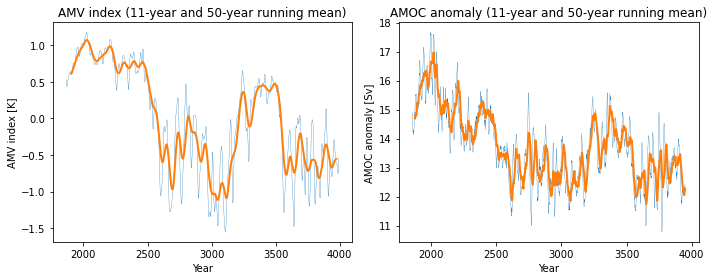

In [8]:
fig1, axs1 = plt.subplots(1,2,figsize=(10,4))
ax1 = axs1.flat

amv_run.rolling(year=11).mean().plot(ax=ax1[0],lw=0.3)
amv_run2.rolling(year=30).mean().plot(ax=ax1[0],lw=2)

amoc.rolling(year=11).mean().plot(ax=ax1[1],lw=0.3)
amoc.rolling(year=30).mean().plot(ax=ax1[1],lw=2)

for ax in ax1:
    ax.set_xlabel('Year')
ax1[0].set_ylabel('AMV index [K]')
ax1[0].set_title('AMV index (11-year and 50-year running mean)')
ax1[1].set_ylabel('AMOC anomaly [Sv]')
ax1[1].set_title('AMOC anomaly (11-year and 50-year running mean)')
fig1.tight_layout()
fig1.savefig('figures/Fig_AMV_AMOC_raw_11-50yr.pdf',format='pdf')

## 50-year running mean of AMOC and AMV

NameError: name 'amv_all' is not defined

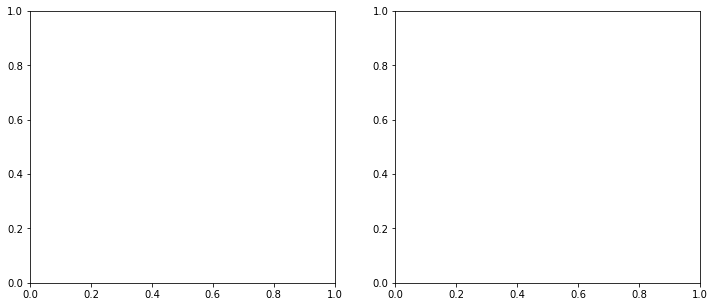

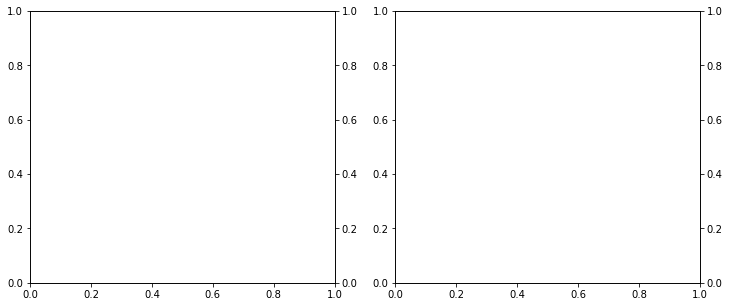

In [14]:
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))

fig2, ax2 = plt.subplots(1,2,figsize=(12,5))
ax21 = ax2[0].twinx()
ax22 = ax2[1].twinx()

# Take first run, then split to two periods
label_list = ['Warm phase','Cold phase']
time_list = [slice('2200-01-01','2400-01-01'), slice('2600-01-01','2800-01-01')]
_amv_list = []
_amoc_list = []
for i,time in enumerate(time_list):
    _amv_list = amv_all[0].sel(time=time)
    _amoc_list = amoc_index[0].sel(time=time)

for i, (amv, amoc) in enumerate( zip(_amv_list, _amoc_list) ):
    
    amoc_d = detrend(amoc, dim='year')
    amv_d = detrend(amv, dim='year')
    
    amv11 = amv_d.rolling(year=11, center=True).mean().dropna('year')
    amoc11 = amoc_d.rolling(year=11, center=True).mean().dropna('year')
    
    amv50 = amv_d.rolling(year=50, center=True).mean().dropna('year')
    amoc50 = amoc_d.rolling(year=50, center=True).mean().dropna('year')
    
    amv_d.plot(ax=ax1[0], c='b', alpha=0.3)
    amv50.plot(ax=ax1[0], c='b')
    amv11.plot(ax=ax2[0], c='k')
    amv50.plot(ax=ax2[1], c='k')
    amoc_d.plot(ax=ax1[1], c='b', alpha=0.3)
    amoc50.plot(ax=ax1[1], c='b')
    amoc11.plot(ax=ax21, c='r')
    amoc50.plot(ax=ax22, c='r')
    
    # anom
    amv11a = amv11 - amv11.mean('year')
    amoc11a = amoc11 - amoc11.mean('year')
    amv50a = amv50 - amv50.mean('year')
    amoc50a = amoc50 - amoc50.mean('year')
    # cov
    cov11 = (amoc11a * amv11a).sum() / len(amoc11a.year)
    cov50 = (amoc50a * amv50a).sum() / len(amoc50a.year)
    # corr
    r11 = cov11 / (amoc11a.std() * amv11a.std())
    r50 = cov50 / (amoc50a.std() * amv50a.std())
    
    #ax2[0].text(x=2750, y=0.5, s='r=%0.2f' % (r11,), 
    #            ha='center', va='center', )
    #ax2[1].text(x=2750, y=0.5, s='r=%0.2f' % (r50,), 
    #            ha='center', va='center', )

ax2[0].set_ylabel('AMV [K]')
ax2[1].set_ylabel('AMV [K]')
ax21.set_ylabel('AMOC [Sv]')
ax22.set_ylabel('AMOC [Sv]')
ax2[0].set_title('r(AMOC,AMV) = %0.2f (11-year lowpass)' % (r11,))
ax2[1].set_title('r(AMOC,AMV) = %0.2f (50-year lowpass)' % (r50,))
#ax2[1].set_title('50-year running mean of AMOC and AMV')
fig1.tight_layout()
fig2.tight_layout()
#fig2.savefig('figures/amoc_amv_corr_lowpass.pdf',format='pdf')

## Wavelet calculations

0.8198514903018198 0.732607095407492
variance =  1.0
lag1 =  0.8378880961257043


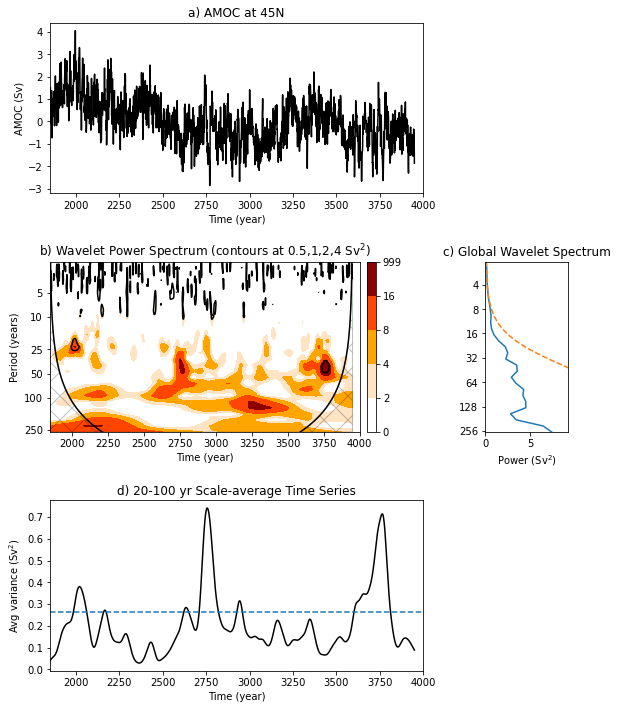

In [10]:
#for j, da_amoc in enumerate( amoc_index ):
if 1:
    
    #amoc = (amoc_anom - amoc_anom.mean('year')).values
    
    # Normalise time series
    amoc = (amoc_anom - amoc_anom.mean('year')).values / np.std(amoc_anom.values, ddof=1)
    
    variance = np.std(amoc, ddof=1) ** 2
    time = amoc_anom.year.values
    xlim = [1850,4000]
    
    [r1,r2] = autocorr( amoc, [1,2] )
    print(r1,r2)
    lag1 = (r1 + np.sqrt(r2)) / 2.
    print('variance = ', variance)
    print('lag1 = ', lag1)
    
    dt = 1 # annual means
    s0 = 2 # start at scale 2 years
    
    n = len(amoc) # length of data
    
    # pad the time series with zeroes (recommended)
    pad = 1  
    
    # this will do 4 sub-octaves per octave
    dj = 0.25
    
    # this says do 7 powers-of-two with dj sub-octaves each
    j1 = 7 / dj  
    
    mother = 'MORLET'
    
    #
    # Wavelet transform
    #
    wave, period, scale, coi = wavelet(amoc, dt, pad, dj, s0, j1, mother)
    
    # compute wavelet power spectrum
    power = (np.abs(wave)) ** 2  
    
    # time-average over all times
    global_ws = (np.sum(power, axis=1) / n)  
    
    # Significance levels
    # (we compare with red noise)
    signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
                         lag1=lag1, mother=mother)
    # expand signif --> (J+1)x(N) array
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
    sig95 = power / sig95  # where ratio > 1, power is significant
    
    # Global wavelet spectrum & significance levels:
    dof = n - scale  # the -scale corrects for padding at edges
    global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
                                lag1=lag1, dof=dof, mother=mother)
    
    # 
    # Average power for 5-15 year periods
    #
    avg = np.logical_and(scale >= 20, scale < 100)
    Cdelta = 0.776  # this is for the MORLET wavelet
    # expand scale --> (J+1)x(N) array
    scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
    scale_avg = power / scale_avg  # [Eqn(24)]
    scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
    
    # significance test
    scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
                                  lag1=lag1, dof=([2, 7.9]), mother=mother)
    
    
    # --- Plot time series
    fig = plt.figure(figsize=(9, 10))
    gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
    plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                        wspace=0, hspace=0)
    plt.subplot(gs[0, 0:3])
    plt.plot(time, amoc, 'k')
    plt.xlim(xlim[:])
    plt.xlabel('Time (year)')
    plt.ylabel('AMOC (Sv)')
    plt.title('a) AMOC at 45N')
    
    #plt.text(time[-1] + 35, 0.5, 'Wavelet Analysis\nC. Torrence & G.P. Compo\n'
    #         'http://paos.colorado.edu/\nresearch/wavelets/',
    #         horizontalalignment='center', verticalalignment='center')
    
    # --- Contour plot wavelet power spectrum
    # plt3 = plt.subplot(3, 1, 2)
    plt3 = plt.subplot(gs[1, 0:3])
    #levels = [0, 1, 2, 4, 8, 999]
    levels = [0, 2, 4, 8, 16, 999]
    # *** or use 'contour'
    CS = plt.contourf(time, period, power, len(levels))
    im = plt.contourf(CS, levels=levels,
                      colors=['white', 'bisque', 'orange', 'orangered', 'darkred'])
    plt.xlabel('Time (year)')
    plt.ylabel('Period (years)')
    plt.title('b) Wavelet Power Spectrum (contours at 0.5,1,2,4 Sv$^2$)')
    plt.xlim(xlim[:])
    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    plt.contour(time, period, sig95, [-99, 1], colors='k')
    # cone-of-influence, anything "below" is dubious
    plt.fill_between(time, coi * 0 + period[-1], coi, facecolor="none",
                     edgecolor="#00000040", hatch='x')
    plt.plot(time, coi, 'k')
    # format y-scale
    plt3.set_yscale('log', base=2, subs=None)
    plt3.set_yticks([1,5,10,25,50,100,250,500])
    plt.ylim([np.min(period), np.max(period)])
    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt3.ticklabel_format(axis='y', style='plain')
    plt3.invert_yaxis()

    # set up the size and location of the colorbar
    #position=fig.add_axes([0.5,0.36,0.2,0.01])
    plt.colorbar(im, orientation='vertical',pad=0.02)
    
    # plt.subplots_adjust(right=0.7, top=0.9)

    # --- Plot global wavelet spectrum
    plt4 = plt.subplot(gs[1, -1])
    plt.plot(global_ws, period)
    plt.plot(global_signif, period, '--')
    plt.xlabel('Power (Sv$^2$)')
    plt.title('c) Global Wavelet Spectrum')
    plt.xlim([0, 1.25 * np.max(global_ws)])
    # format y-scale
    plt4.set_yscale('log', base=2, subs=None)
    plt.ylim([np.min(period), np.max(period)])
    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt4.ticklabel_format(axis='y', style='plain')
    plt4.invert_yaxis()
    
    # --- Plot 2--8 yr scale-average time series
    plt.subplot(gs[2, 0:3])
    plt.plot(time, scale_avg, 'k')
    plt.xlim(xlim[:])
    plt.xlabel('Time (year)')
    plt.ylabel('Avg variance (Sv$^2$)')
    plt.title('d) 20-100 yr Scale-average Time Series')
    plt.plot(xlim, scaleavg_signif + [0, 0], '--')
    
    plt.savefig('figures/Fig_amoc_wavelet.pdf',format='pdf')
    

## Wavelet of AMV

In [1]:
#for j, da_amv in enumerate( amv_all ):
# No need to loop over all experiments
# All experiments have been merged into one dataset
if 1:
    
    # amv_run is AMV index with 11-year centered running mean
    #amv = (amv_run - amv_run.mean('year'))[6:-6].values
    
    #amv = (amv_index - amv_index.mean('year')).values
    # Normalize
    amv = (amv_index - amv_index.mean('year')).values / np.std(amv_index.values, ddof=1)
    variance = np.std(amv, ddof=1) ** 2
    #time = amv_run.year[6:-6].values
    time = amv_index.year.values
    
    xlim = [1850,4000]
    
    [r1,r2] = autocorr( amv, [1,2] )
    print(r1,r2)
    lag1 = (r1 + np.sqrt(r2)) / 2.
    print('variance = ', variance)
    print('lag1 = ', lag1)
    
    dt = 1 # annual means
    s0 = 2 # start at scale 2 years
    
    n = len(amv) # length of data
    
    # pad the time series with zeroes (recommended)
    pad = 1  
    
    # this will do 4 sub-octaves per octave
    dj = 0.25
    
    # this says do 7 powers-of-two with dj sub-octaves each
    j1 = 7 / dj  
    
    mother = 'MORLET'
    
    #
    # Wavelet transform
    #
    wave, period, scale, coi = wavelet(amv, dt, pad, dj, s0, j1, mother)
    
    # compute wavelet power spectrum
    power = (np.abs(wave)) ** 2  
    
    # time-average over all times
    global_ws = (np.sum(power, axis=1) / n)  
    
    # Significance levels
    # (we compare with red noise)
    signif = wave_signif(([variance]), dt=dt, sigtest=0, scale=scale,
                         lag1=lag1, mother=mother)
    # expand signif --> (J+1)x(N) array
    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
    sig95 = power / sig95  # where ratio > 1, power is significant
    
    # Global wavelet spectrum & significance levels:
    dof = n - scale  # the -scale corrects for padding at edges
    global_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=1,
                                lag1=lag1, dof=dof, mother=mother)
    
    # 
    # Average power for 5-15 year periods
    #
    avg = np.logical_and(scale >= 20, scale < 100)
    Cdelta = 0.776  # this is for the MORLET wavelet
    # expand scale --> (J+1)x(N) array
    scale_avg = scale[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
    scale_avg = power / scale_avg  # [Eqn(24)]
    scale_avg = dj * dt / Cdelta * sum(scale_avg[avg, :])  # [Eqn(24)]
    
    # significance test
    scaleavg_signif = wave_signif(variance, dt=dt, scale=scale, sigtest=2,
                                  lag1=lag1, dof=([2, 7.9]), mother=mother)
    
    
    # --- Plot time series
    fig = plt.figure(figsize=(9, 10))
    gs = GridSpec(3, 4, hspace=0.4, wspace=0.75)
    plt.subplots_adjust(left=0.1, bottom=0.05, right=0.9, top=0.95,
                        wspace=0, hspace=0)
    plt.subplot(gs[0, 0:3])
    plt.plot(time, amv, 'k')
    plt.xlim(xlim[:])
    plt.xlabel('Time (year)')
    plt.ylabel('AMV (K)')
    plt.title('a) AMV index')
    
    # --- Contour plot wavelet power spectrum
    # plt3 = plt.subplot(3, 1, 2)
    plt3 = plt.subplot(gs[1, 0:3])
    #levels = [0, 0.2, 0.5, 2, 4, 12]
    #levels = [0, 0.1, 0.2, 0.5, 1, 2, 4, 8, 16]
    levels = [0, 2, 4, 8, 16, 999]
    # *** or use 'contour'
    CS = plt.contourf(time, period, power, len(levels))
    im = plt.contourf(CS, levels=levels,
                      colors=['white', 'bisque', 'orange', 'orangered', 'darkred'],
                     extend="both")
    plt.xlabel('Time (year)')
    plt.ylabel('Period (years)')
    plt.title('b) Wavelet Power Spectrum')
    plt.xlim(xlim[:])
    # 95# significance contour, levels at -99 (fake) and 1 (95# signif)
    plt.contour(time, period, sig95, [-99, 1], colors='k')
    # cone-of-influence, anything "below" is dubious
    plt.fill_between(time, coi * 0 + period[-1], coi, facecolor="none",
                     edgecolor="#00000040", hatch='x')
    plt.plot(time, coi, 'k')
    # format y-scale
    plt3.set_yscale('log', base=2, subs=None)
    plt3.set_yticks([1,5,10,25,50,100,250,500])
    plt.ylim([np.min(period), np.max(period)])
    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt3.ticklabel_format(axis='y', style='plain')
    plt3.invert_yaxis()

    # set up the size and location of the colorbar
    #position=fig.add_axes([0.5,0.36,0.2,0.01])
    plt.colorbar(im, orientation='vertical',pad=0.02, spacing="uniform")
    
    # plt.subplots_adjust(right=0.7, top=0.9)

    # --- Plot global wavelet spectrum
    plt4 = plt.subplot(gs[1, -1])
    plt.plot(global_ws, period)
    plt.plot(global_signif, period, '--')
    plt.xlabel('Power (Sv$^2$)')
    plt.title('c) Global Wavelet Spectrum')
    plt.xlim([0, 1.25 * np.max(global_ws)])
    # format y-scale
    plt4.set_yscale('log', base=2, subs=None)
    plt.ylim([np.min(period), np.max(period)])
    ax = plt.gca().yaxis
    ax.set_major_formatter(ticker.ScalarFormatter())
    plt4.ticklabel_format(axis='y', style='plain')
    plt4.invert_yaxis()
    
    # --- Plot 2--8 yr scale-average time series
    plt.subplot(gs[2, 0:3])
    plt.semilogy(time, scale_avg, 'k')
    plt.xlim(xlim[:])
    plt.xlabel('Time (year)')
    plt.ylabel('Avg variance (K$^2$)')
    plt.title('d) 20-100 yr Scale-average Time Series')
    plt.plot(xlim, scaleavg_signif + [0, 0], '--')
    
    plt.savefig('figures/Fig_amv_wavelet.pdf',format='pdf')

NameError: name 'amv_index' is not defined